In [1]:
import os
import sys
#path environment
if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")
import traci

import xml.etree.ElementTree as ET

import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.api as sm
import numpy as np

In [2]:
file_output = "my_output_file_grid_min.xml"

sumo_cmd = ['sumo', 
            '--duration-log.statistics', 
            '--tripinfo-output', file_output, 
            '-c', 'maps/grid/grid.sumo.cfg']

In [3]:
def reroute_vehicle(vehicle_id):
    # Get the vehicle's current edge
    current_edge = traci.vehicle.getRoadID(vehicle_id)

    # Get the current route
    current_route = traci.vehicle.getRoute(vehicle_id)

    # Initialize variables for best route selection
    best_route = current_route
    min_time_loss = float('inf')

    # Iterate over the current route to find alternative edges
    for edge in current_route:
        try:
            # Get the travel time for the edge
            edge_travel_time = traci.edge.getTraveltime(edge)

            # Compare to find the edge with the minimum travel time
            if edge_travel_time < min_time_loss:
                min_time_loss = edge_travel_time
                best_route = current_route
        except traci.exceptions.TraCIException:
            continue

    # Set the new route if it's different and has less time loss
    if best_route != current_route:
        traci.vehicle.setRoute(vehicle_id, best_route)



def analyze_time_loss(file_path):
    # Parse the XML file
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Initialize variables for analysis
    total_time_loss = 0.0
    total_waiting_time = 0.0
    total_duration = 0.0
    total_reroutes = 0
    vehicle_count = 0

    # Iterate over each tripinfo element in the XML
    for trip in root.findall('tripinfo'):
        time_loss = float(trip.get('timeLoss'))
        waiting_time = float(trip.get('waitingTime'))
        duration = float(trip.get('duration'))
        reroutes = int(trip.get('rerouteNo'))
        
        total_time_loss += time_loss
        total_waiting_time += waiting_time
        total_duration += duration
        total_reroutes += reroutes
        vehicle_count += 1

    # Calculate averages
    average_time_loss = total_time_loss / vehicle_count if vehicle_count > 0 else 0
    average_waiting_time = total_waiting_time / vehicle_count if vehicle_count > 0 else 0
    average_duration = total_duration / vehicle_count if vehicle_count > 0 else 0
    average_reroutes = total_reroutes / vehicle_count if vehicle_count > 0 else 0

    # Store results in a dictionary
    results = {
        'Total Vehicles': vehicle_count,
        'Total Time Loss': total_time_loss,
        'Average Time Loss': average_time_loss,
        'Total Waiting Time': total_waiting_time,
        'Average Waiting Time': average_waiting_time,
        'Average Duration': average_duration,
        'Total Reroutes': total_reroutes,
        'Average Reroutes': average_reroutes
    }
    return results


In [4]:
reroute_intervals = [5, 30, 60, 120]  # Different intervals to test
STEPTOTAL = 3600
simulation_results = []

for reroute_interval in reroute_intervals:
    print(f"Running simulation with reroute interval: {reroute_interval} seconds")
    
    # Start SUMO
    traci.start(sumo_cmd)

    step = 0
    try:
        while step < STEPTOTAL:
            traci.simulationStep()
    
            if step % reroute_interval == 0:
                for vehicle_id in traci.vehicle.getIDList():
                    reroute_vehicle(vehicle_id)
    
            step += 1
    finally:
        traci.close()


    
    # Analyze the results and store them in the simulation_results list
    results = analyze_time_loss(file_output)
    results['Reroute Interval'] = reroute_interval  # Add the interval as a data point
    simulation_results.append(results)



Running simulation with reroute interval: 5 seconds
 Retrying in 1 seconds
***Starting server on port 55197 ***
Loading net-file from 'maps/grid/grid.net.xml' ... done (10ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.
Step #3600.00 (0ms ?*RT. ?UPS, TraCI: 0ms, vehicles TOT 4497 ACT 144 BUF 2)               
Simulation ended at time: 3600.00
Reason: TraCI requested termination.
Performance: 
 Duration: 11.20s
 TraCI-Duration: 10.23s
 Real time factor: 321.371
 UPS: 45486.073915
Vehicles: 
 Inserted: 4497 (Loaded: 4500)
 Running: 144
 Waiting: 2
Statistics (avg of 4353):
 RouteLength: 972.09
 Speed: 9.01
 Duration: 114.83
 WaitingTime: 19.10
 TimeLoss: 42.24
 DepartDelay: 1.80

Running simulation with reroute interval: 30 seconds
 Retrying in 1 seconds
***Starting server on port 50463 ***
Loading net-file from 'maps/grid/grid.net.xml' ... done (10ms).
Loading done.
Simulation version 1.18.0 started with time: 0.00.
Step #3600.00 (0ms ?*RT. ?UPS, TraCI: 0ms, vehicle

In [5]:
# Convert results to a DataFrame
df = pd.DataFrame(simulation_results)
df

,Total Vehicles,Total Time Loss,Average Time Loss,Total Waiting Time,Average Waiting Time,Average Duration,Total Reroutes,Average Reroutes,Reroute Interval
0,4353,183857.1,42.236871,83129.0,19.096945,114.826097,0,0.0,5
1,4353,183857.1,42.236871,83129.0,19.096945,114.826097,0,0.0,30
2,4353,183857.1,42.236871,83129.0,19.096945,114.826097,0,0.0,60
3,4353,183857.1,42.236871,83129.0,19.096945,114.826097,0,0.0,120


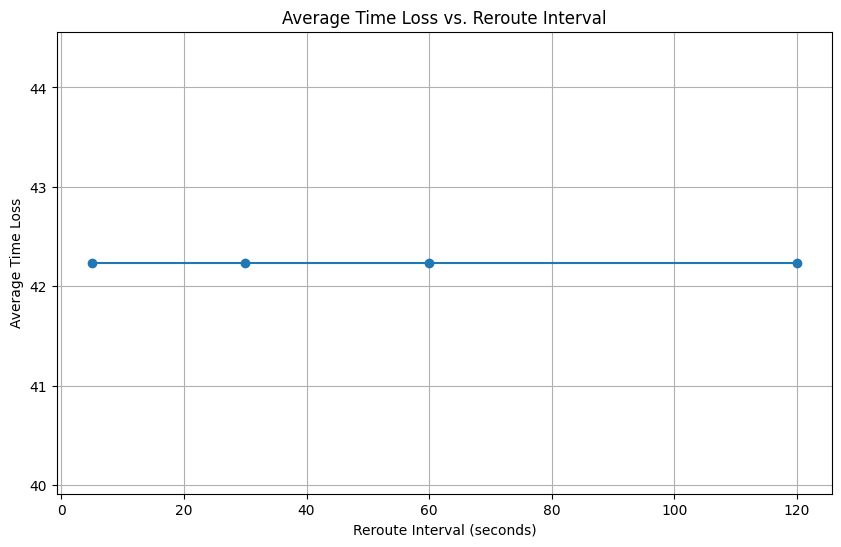

In [6]:


plt.figure(figsize=(10, 6))
plt.plot(df['Reroute Interval'], df['Average Time Loss'], marker='o')
plt.title('Average Time Loss vs. Reroute Interval')
plt.xlabel('Reroute Interval (seconds)')
plt.ylabel('Average Time Loss')
plt.grid(True)
plt.show()


In [7]:
# Display descriptive statistics
df.describe()

,Total Vehicles,Total Time Loss,Average Time Loss,Total Waiting Time,Average Waiting Time,Average Duration,Total Reroutes,Average Reroutes,Reroute Interval
count,4.0,4.0,4.000000,4.0,4.000000,4.000000,4.0,4.0,4.000000
mean,4353.0,183857.1,42.236871,83129.0,19.096945,114.826097,0.0,0.0,53.750000
std,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,49.560569
min,4353.0,183857.1,42.236871,83129.0,19.096945,114.826097,0.0,0.0,5.000000
25%,4353.0,183857.1,42.236871,83129.0,19.096945,114.826097,0.0,0.0,23.750000
50%,4353.0,183857.1,42.236871,83129.0,19.096945,114.826097,0.0,0.0,45.000000
75%,4353.0,183857.1,42.236871,83129.0,19.096945,114.826097,0.0,0.0,75.000000
max,4353.0,183857.1,42.236871,83129.0,19.096945,114.826097,0.0,0.0,120.000000


In [8]:
# Specific statistics for each reroute interval
grouped_stats = df.groupby('Reroute Interval').agg(['mean', 'std', 'min', 'max'])
grouped_stats

Total Vehicles                 Total Time Loss                \
                           mean std   min   max            mean std       min   
Reroute Interval                                                                
5                        4353.0 NaN  4353  4353        183857.1 NaN  183857.1   
30                       4353.0 NaN  4353  4353        183857.1 NaN  183857.1   
60                       4353.0 NaN  4353  4353        183857.1 NaN  183857.1   
120                      4353.0 NaN  4353  4353        183857.1 NaN  183857.1   

                           Average Time Loss      ... Average Duration  \
                       max              mean std  ...              min   
Reroute Interval                                  ...                    
5                 183857.1         42.236871 NaN  ...       114.826097   
30                183857.1         42.236871 NaN  ...       114.826097   
60                183857.1         42.236871 NaN  ...       114.826097   
120               183857.1         42.236871 NaN  ...       114.826097   

                             Total Reroutes             Average Reroutes      \
                         max           mean std min max             mean std   
Reroute Interval                                                               
5                 114.826097            0.0 NaN   0   0              0.0 NaN   
30                114.826097            0.0 NaN   0   0              0.0 NaN   
60                114.826097            0.0 NaN   0   0              0.0 NaN   
120               114.826097            0.0 NaN   0   0              0.0 NaN   

                            
                  min  max  
Reroute Interval            
5                 0.0  0.0  
30                0.0  0.0  
60                0.0  0.0  
120               0.0  0.0  

[4 rows x 32 columns]

In [9]:
# Compute correlation matrix
correlation_matrix = df.corr()

# Display correlation matrix
correlation_matrix

,Total Vehicles,Total Time Loss,Average Time Loss,Total Waiting Time,Average Waiting Time,Average Duration,Total Reroutes,Average Reroutes,Reroute Interval
Total Vehicles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total Time Loss,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Average Time Loss,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total Waiting Time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Average Waiting Time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Average Duration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total Reroutes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Average Reroutes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Reroute Interval,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


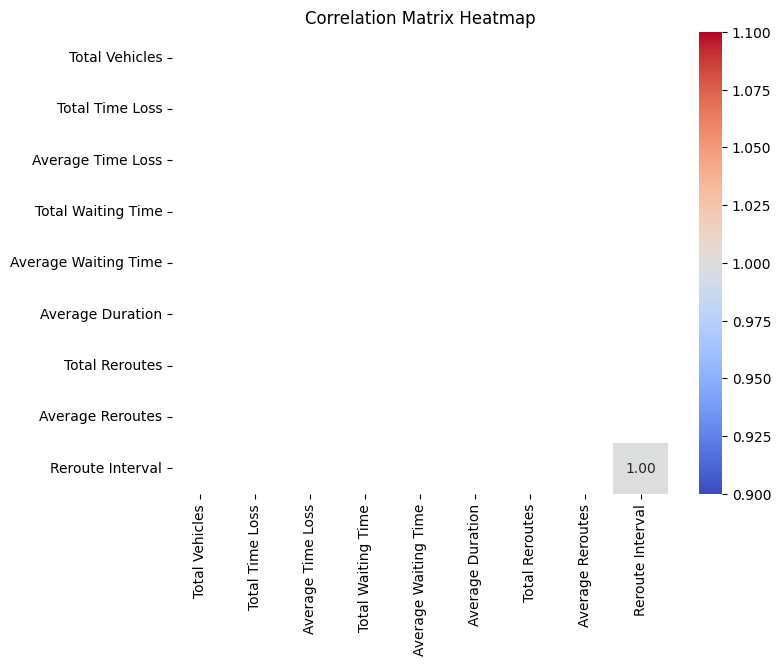

In [10]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()


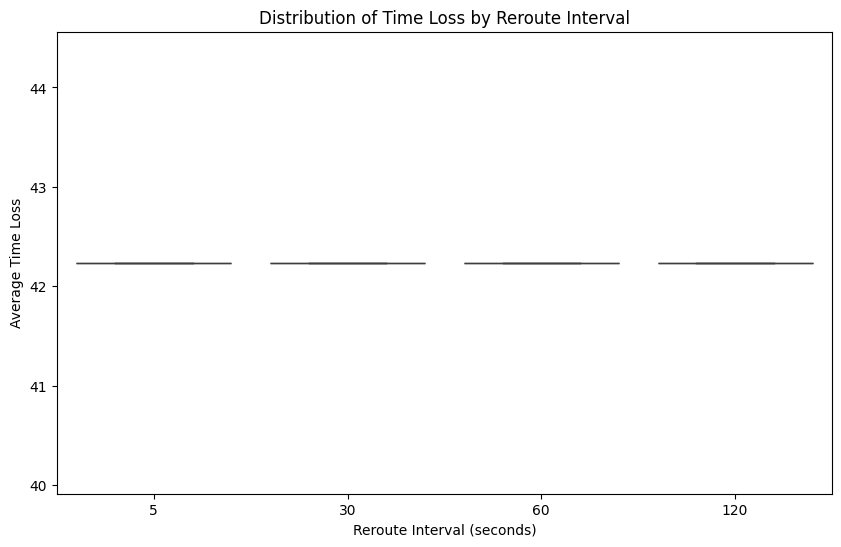

In [11]:


plt.figure(figsize=(10, 6))
sns.boxplot(x='Reroute Interval', y='Average Time Loss', data=df)
plt.title('Distribution of Time Loss by Reroute Interval')
plt.xlabel('Reroute Interval (seconds)')
plt.ylabel('Average Time Loss')
plt.show()


In [12]:
# Add a constant term for the intercept in the regression model
X = sm.add_constant(df['Reroute Interval'])
y = df['Average Time Loss']

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression analysis
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:      Average Time Loss   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -2.000
Date:                Tue, 03 Sep 2024   Prob (F-statistic):               1.00
Time:                        22:27:26   Log-Likelihood:                 124.19
No. Observations:                   4   AIC:                            -244.4
Df Residuals:                       2   BIC:                            -245.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               42.2369      9e-15  

/usr/local/lib/python3.8/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


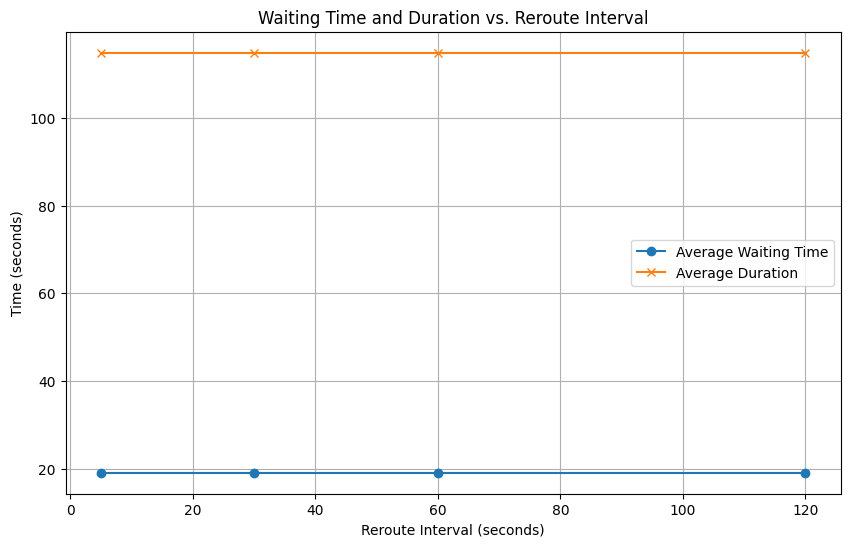

In [13]:
# Plot waiting time vs reroute interval
plt.figure(figsize=(10, 6))
plt.plot(df['Reroute Interval'], df['Average Waiting Time'], marker='o', label='Average Waiting Time')
plt.plot(df['Reroute Interval'], df['Average Duration'], marker='x', label='Average Duration')
plt.title('Waiting Time and Duration vs. Reroute Interval')
plt.xlabel('Reroute Interval (seconds)')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()


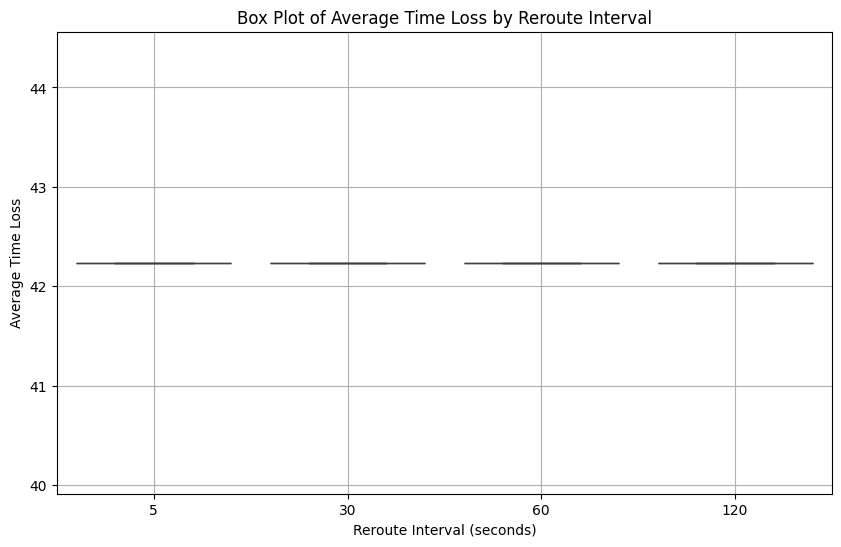

In [14]:
# Create a box plot for Average Time Loss vs. Reroute Interval
plt.figure(figsize=(10, 6))
sns.boxplot(x='Reroute Interval', y='Average Time Loss', data=df)
plt.title('Box Plot of Average Time Loss by Reroute Interval')
plt.xlabel('Reroute Interval (seconds)')
plt.ylabel('Average Time Loss')
plt.grid(True)

# Show the plot
plt.show()

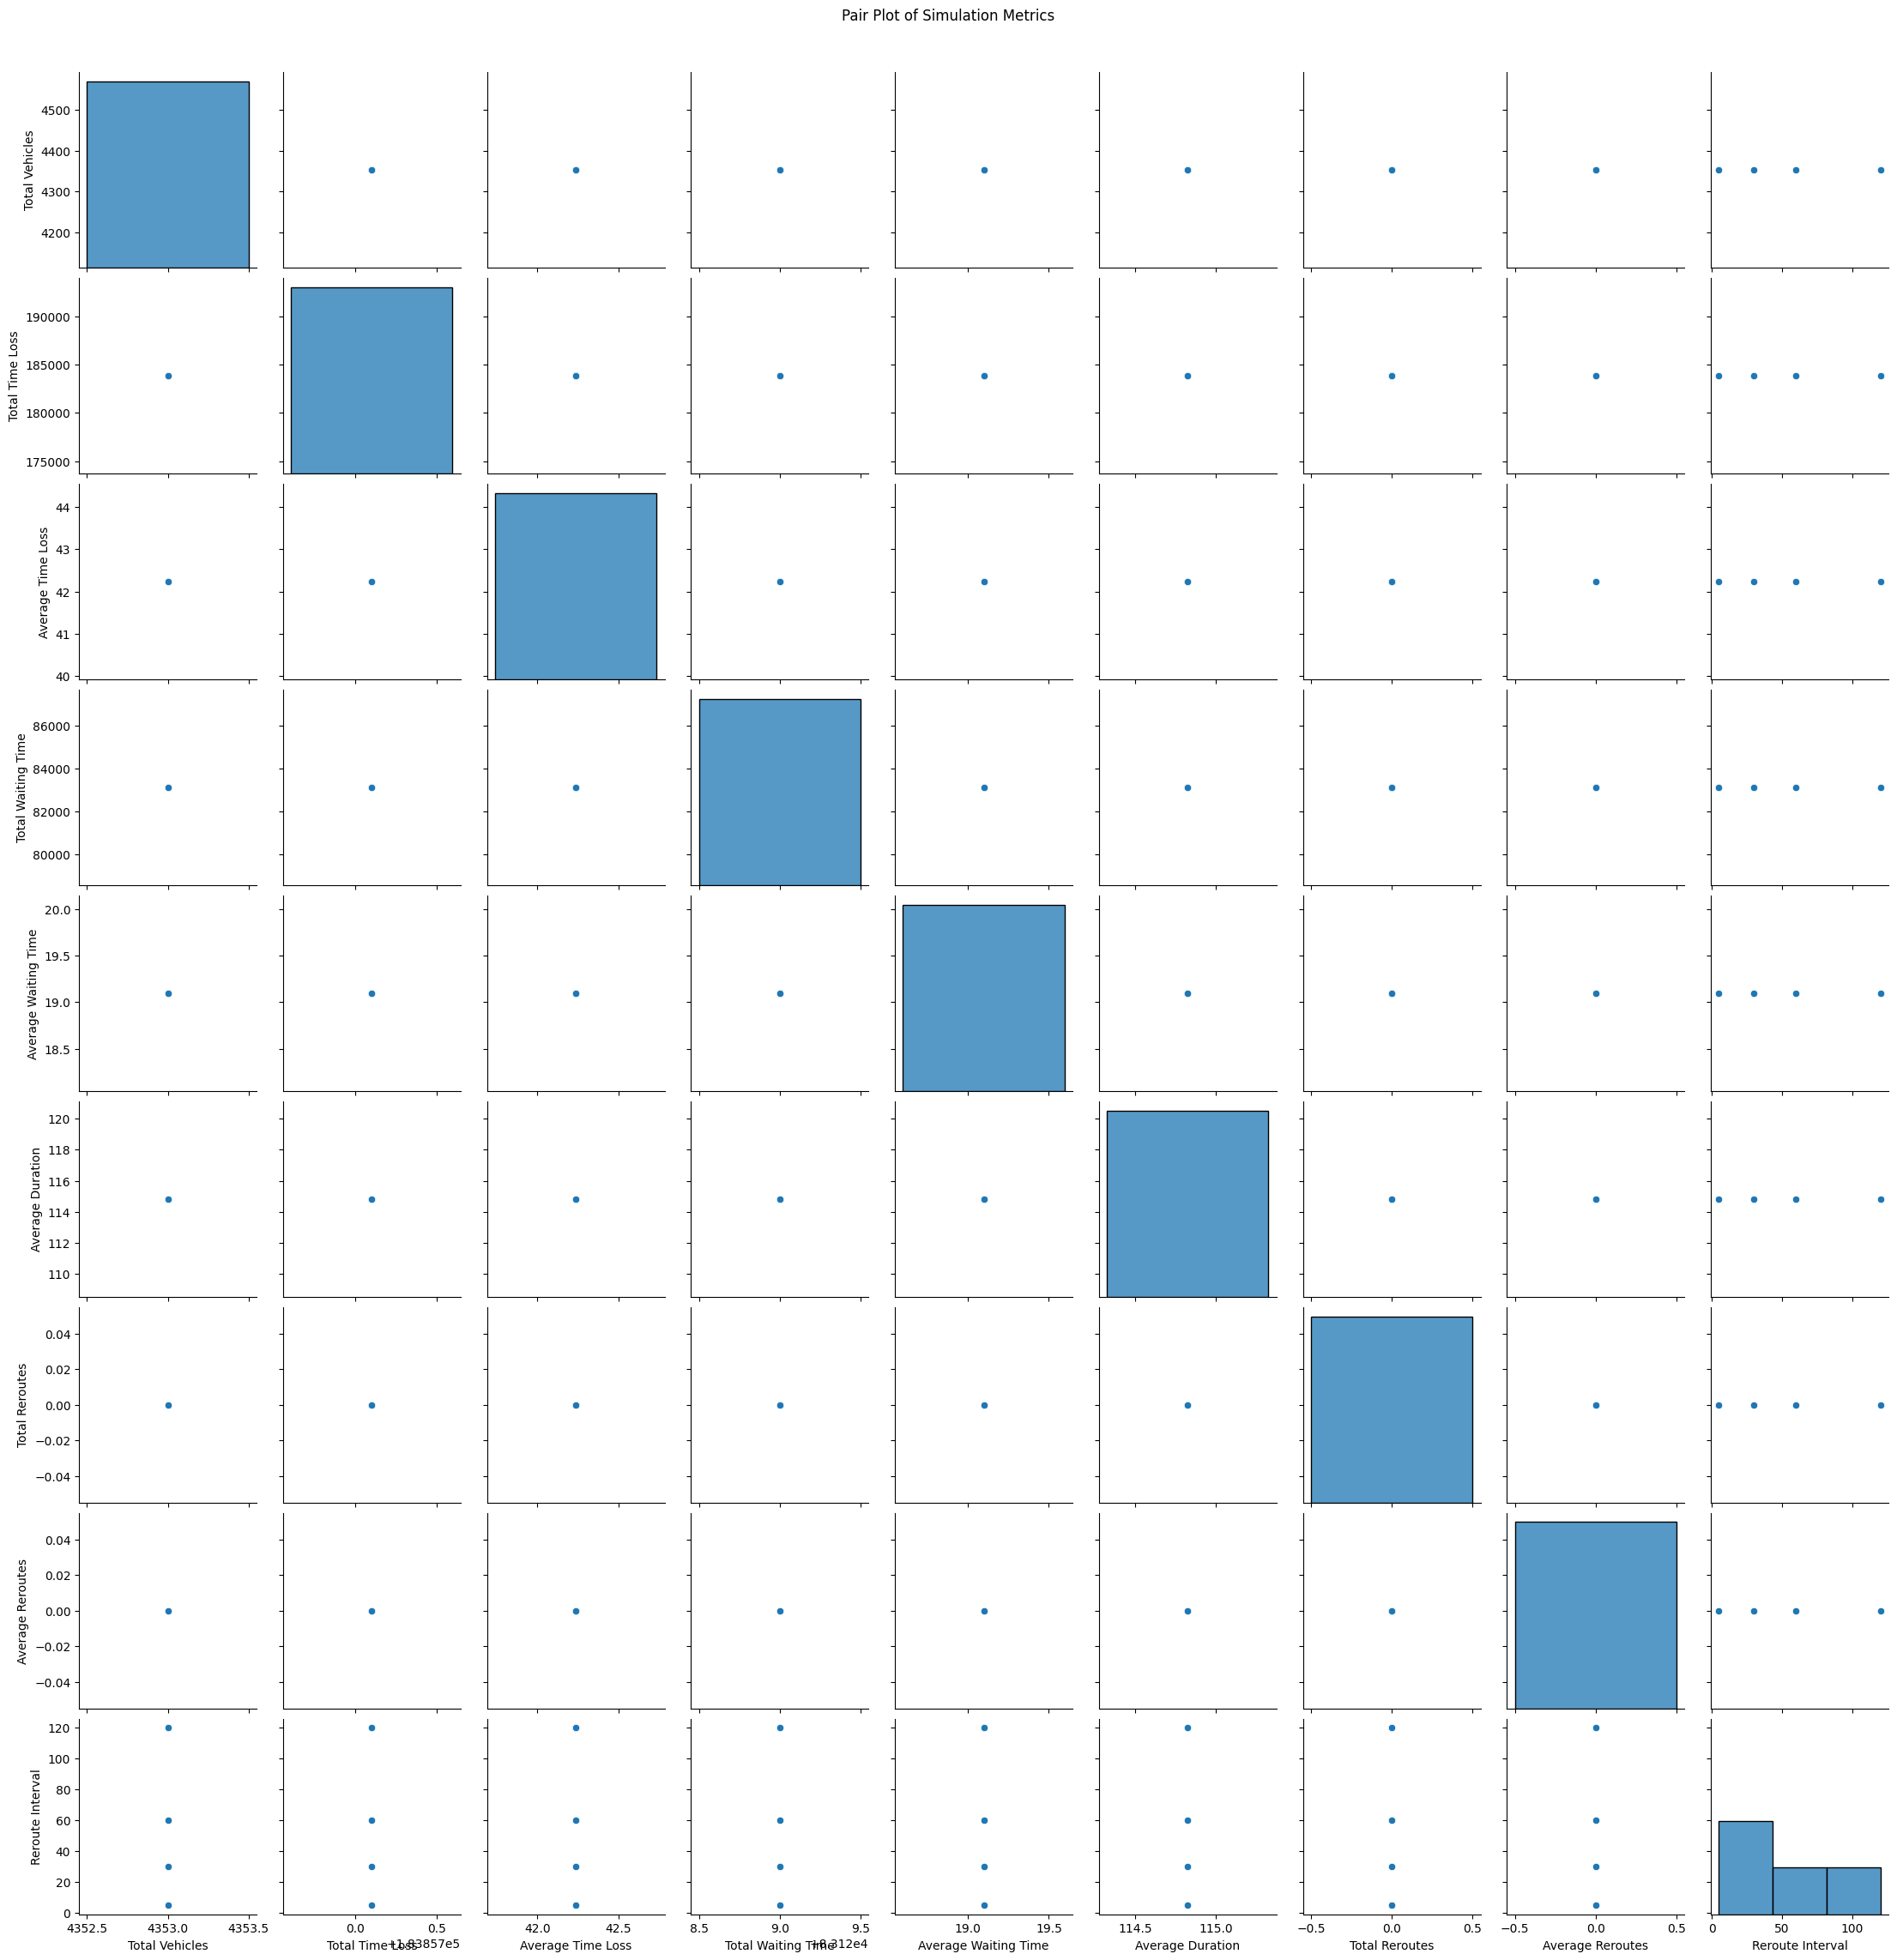

In [15]:
sns.pairplot(df)
plt.suptitle('Pair Plot of Simulation Metrics', y=1.02)
plt.show()